In [1]:
#importing basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load dataframe
data = pd.read_csv('RanBenign_set.csv', index_col=0)
data.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.217.2.174-10.42.0.211-443-51023-6,10.42.0.211,51023,172.217.2.174,443,6,16/06/2017 03:55:47,151054,6,8,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,172.217.2.174-10.42.0.211-443-51023-6,10.42.0.211,51023,172.217.2.174,443,6,16/06/2017 03:55:47,349,2,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,172.217.12.174-10.42.0.211-443-34259-6,10.42.0.211,34259,172.217.12.174,443,6,16/06/2017 03:55:52,119,2,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,172.217.10.74-10.42.0.211-443-55509-6,10.42.0.211,55509,172.217.10.74,443,6,16/06/2017 03:55:53,37055,1,1,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,172.217.2.174-10.42.0.211-443-44852-6,10.42.0.211,44852,172.217.2.174,443,6,16/06/2017 03:55:58,178727,6,7,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
#check class counts
sizes = data['Label'].value_counts(sort=1)
print(sizes)

1    348943
0    249245
Name: Label, dtype: int64


In [4]:
#eliminating unimportant and duplicate columns 
data=data.drop([' Timestamp', 'Flow ID', ' Source IP' ], axis=1)
data=data.drop([' Destination IP', ' Fwd Header Length.1'  ], axis=1)
#eliminating constant columns
data=data.drop([' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags' ], axis=1)
data=data.drop([' RST Flag Count', ' CWE Flag Count', ' ECE Flag Count'  ], axis=1)
data=data.drop(['Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate' ], axis=1)
data=data.drop([' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'  ], axis=1)

In [5]:
#check null values
data.isnull().sum()

 Source Port          0
 Destination Port     0
 Protocol             0
 Flow Duration        0
 Total Fwd Packets    0
                     ..
Idle Mean             0
 Idle Std             0
 Idle Max             0
 Idle Min             0
Label                 0
Length: 68, dtype: int64

In [6]:
#reducing dataframe by selecting 20 best features 
from sklearn.feature_selection import SelectKBest
def select_k_best(score, X, Y):
    selector = SelectKBest(score, k=20)
    X_ = X.fillna(X.mean())
    selector.fit_transform(X_, Y)
    names = X.columns.values[selector.get_support()]
    scores = selector.scores_[selector.get_support()]
    names_scores = list(zip(names, scores))
    df_reduced = pd.DataFrame(data=names_scores, columns=['feature_names', 'score'])
    df_reduced = df_reduced.sort_values(['score', 'feature_names'], ascending=[False, True])
    print(df_reduced)
    return df_reduced.feature_names

In [7]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
frs_anova = select_k_best(f_classif, data[data.columns.difference(['Label'])], data.Label)
d1=frs_anova.values
d2=np.append(d1,'Label')
data=data[d2]

              feature_names        score
15           URG Flag Count  1407.521210
0            ACK Flag Count  1219.633517
4              Flow IAT Min   678.537246
8     Fwd Packet Length Max   598.757829
11        Max Packet Length   580.961184
5            Flow Packets/s   559.131100
18            Fwd Packets/s   545.335037
3             Flow IAT Mean   541.313890
12        Min Packet Length   514.359908
6               Fwd IAT Min   494.739594
13           PSH Flag Count   393.915861
7               Fwd IAT Std   379.345927
16              Active Mean   365.046932
1                Active Max   363.887218
19   Init_Win_bytes_forward   358.758382
14                 Protocol   356.299112
17            Fwd IAT Total   312.188385
10    Fwd Packet Length Std   304.848407
2      Avg Fwd Segment Size   298.562383
9    Fwd Packet Length Mean   298.562383


In [8]:
data.columns.values

array([' URG Flag Count', ' ACK Flag Count', ' Flow IAT Min',
       ' Fwd Packet Length Max', ' Max Packet Length', ' Flow Packets/s',
       'Fwd Packets/s', ' Flow IAT Mean', ' Min Packet Length',
       ' Fwd IAT Min', ' PSH Flag Count', ' Fwd IAT Std', 'Active Mean',
       ' Active Max', 'Init_Win_bytes_forward', ' Protocol',
       'Fwd IAT Total', ' Fwd Packet Length Std', ' Avg Fwd Segment Size',
       ' Fwd Packet Length Mean', 'Label'], dtype=object)

In [9]:
# Separatating & assigning features and target columns to X & y

y = data['Label']
X = data.drop('Label',axis=1)
X.shape, y.shape

((598188, 20), (598188,))

In [10]:
# Splitting the dataset into train and test sets: 75-25 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25, random_state = 100)
X_train.shape, X_test.shape

((448641, 20), (149547, 20))

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion="gini", n_estimators=200, max_depth=75, min_samples_split=7, random_state=0, n_jobs=-1)

In [13]:
%%time
clf.fit(X_train_scaled, y_train)

CPU times: total: 8min 43s
Wall time: 1min 32s


RandomForestClassifier(max_depth=75, min_samples_split=7, n_estimators=200,
                       n_jobs=-1, random_state=0)

In [14]:
y_pred = clf.predict(X_test_scaled)
y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7542846061773222

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.68     62023
           1       0.76      0.84      0.80     87524

    accuracy                           0.75    149547
   macro avg       0.75      0.74      0.74    149547
weighted avg       0.75      0.75      0.75    149547



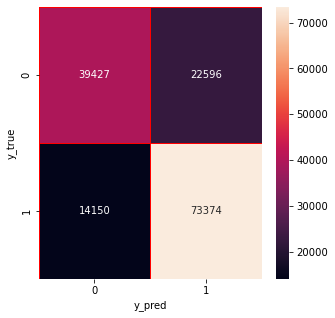

In [17]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()